In [1]:
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import disrnn
import rnn_utils
from rnn_utils import DatasetRNN

# Load Data

In [2]:
matDf = loadmat('..\data\data_for_Meike.mat')['data']
features = matDf.dtype.names
df = pd.DataFrame(np.squeeze(np.array(matDf.tolist())).T, columns=features).drop(columns=['label','Spcorrect1', 'Spcorrect2', 'Snoise']).sort_values(by=['subject', 'trial'])
df['Reward'] = (df['select'] == 1) * df['Sacc'] + (df['select'] == -1) * df['Pacc']
features = ['dtheta', 'type', 'Pchoice', 'Preport', 'Pacc', 'Schoice', 'Sacc', 'Srt1', 'select', 'Reward', 'Sreport'] 
target = ['Sreport']

In [3]:
df

,subject,block,trial,dtheta,type,Pchoice,Preport,Pacc,Schoice,Sreport,Sacc,Srt1,Srt2,select,Reward
0,1.0,1.0,1.0,0.18,2.0,-1.0,5.0,0.0,1.0,3.0,1.0,0.907,2576.0,-1.0,0.0
1,1.0,1.0,2.0,-0.11,2.0,-1.0,6.0,1.0,-1.0,4.0,1.0,0.380,1483.0,-1.0,1.0
2,1.0,1.0,3.0,-0.27,1.0,-1.0,3.0,1.0,-1.0,6.0,1.0,0.388,940.0,1.0,1.0
3,1.0,1.0,4.0,0.18,2.0,1.0,6.0,1.0,1.0,5.0,1.0,0.399,1505.0,-1.0,1.0
4,1.0,1.0,5.0,0.05,1.0,-1.0,3.0,0.0,1.0,1.0,1.0,1.234,665.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7675,30.0,4.0,252.0,-0.13,2.0,1.0,3.0,0.0,-1.0,4.0,1.0,0.475,1640.0,1.0,1.0
7676,30.0,4.0,253.0,0.13,1.0,1.0,5.0,1.0,-1.0,2.0,0.0,0.507,1655.0,-1.0,1.0
7677,30.0,4.0,254.0,0.05,2.0,-1.0,3.0,0.0,-1.0,4.0,0.0,0.308,1790.0,1.0,0.0
7678,30.0,4.0,255.0,0.05,2.0,1.0,4.0,1.0,-1.0,3.0,0.0,1.449,1584.0,-1.0,1.0


Text(0.5, 0, 'Log-Likelihood')

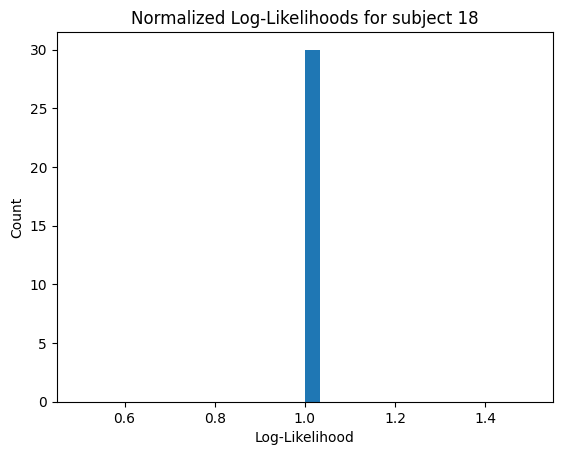

In [4]:
likelihoods = np.ones((30,2))
plt.hist(likelihoods[:,0], bins=30)
plt.title('Normalized Log-Likelihoods for subject 18')
plt.ylabel('Count')
plt.xlabel('Log-Likelihood')

# Create Train and Test

In [5]:
batch_size = None
tr = 4
LOOCV = True # set to true if you want to do leave-one-out cross validation
leave_out_idx = 15 # index of the subject to leave out

if LOOCV:
    n_trials = df['trial'].unique().size
    target_size = df['Sreport'].unique().size
    n_sessions = df['subject'].unique().size
    n_blocks = df['block'].unique().size
    features_number = len(features)

    xsTrain = np.zeros((n_trials, n_sessions, features_number))
    ysTrain = np.zeros((n_trials, n_sessions, 1))
    xsTest = np.zeros((n_trials, 1, features_number))
    ysTest = np.zeros((n_trials, 1, 1))

    for i, subject in enumerate(np.sort(df['subject'].unique())):
        xsTrain[:, i, :] = df[df['subject'] == subject][features].values
        ysTrain[:, i, :] = df[df['subject'] == subject][target].values
        xsTest[:, 0, :] = df[df['subject'] == subject][features].values[leave_out_idx,:]
        ysTest[:, 0, :] = df[df['subject'] == subject][target].values[leave_out_idx,:]

    # Exclude leave_out_idx from xsTrain and ysTrain
    xsTrain = np.delete(xsTrain, leave_out_idx, axis=1)
    ysTrain = np.delete(ysTrain, leave_out_idx, axis=1)

    n_sessions -= 1

    border = int(n_trials / len(df['block'].unique()))

    indices_xsTrain = np.arange(0, n_blocks * border, border)
    indices_xsTest = [0]
    indices_ysTrain = np.arange(border, n_blocks * border, border)
    
    # Add a dummy input at the beginning of each block. First step has a target but no input
    xsTrain_padded_LOOCV = np.insert(xsTrain, indices_xsTrain, np.zeros((1, n_sessions, features_number)), axis=0)
    xsTest_padded_LOOCV = np.insert(xsTest, indices_xsTest, np.zeros((1, 1, features_number)), axis=0)

    # Add a dummy target at the end of each block. Last step has input but no target
    ysTrain_padded_LOOCV  = np.insert(ysTrain, indices_ysTrain, -1*np.ones((1, n_sessions, 1)), axis=0)
    
    # np.insert inserts before given idx, so the last row we need to append manually
    ysTrain_padded_LOOCV = np.concatenate((ysTrain_padded_LOOCV, -1*np.ones((1,n_sessions,1))), axis=0)
    ysTest_padded_LOOCV = np.concatenate((ysTest, -1*np.ones((1,1,1))), axis=0)

    train = DatasetRNN(xsTrain_padded_LOOCV, ysTrain_padded_LOOCV, batch_size)
    test = DatasetRNN(xsTest_padded_LOOCV, ysTest_padded_LOOCV, batch_size)

else: 

    df_test = df[df['block'] >= tr]
    df_train = df[df['block'] < tr]

    n_trials_train = df_train['trial'].unique().size
    n_trials_test = df_test['trial'].unique().size
    target_size = df['Sreport'].unique().size
    n_sessions = df['subject'].unique().size 
    n_blocks = df['block'].unique().size
    features_number = len(features)

    xsTrain = np.zeros((n_trials_train, n_sessions, features_number))
    ysTrain = np.zeros((n_trials_train, n_sessions, 1))
    xsTest = np.zeros((n_trials_test, n_sessions, features_number))
    ysTest = np.zeros((n_trials_test, n_sessions, 1))

    for i, subject in enumerate(df['subject'].unique()):    
        xsTrain[:, i, :] = df_train[df_train['subject'] == subject][features].values
        ysTrain[:, i, :] = df_train[df_train['subject'] == subject][target].values
        xsTest[:, i, :] = df_test[df_test['subject'] == subject][features].values
        ysTest[:, i, :] = df_test[df_test['subject'] == subject][target].values    
        
    border = int(n_trials_train / len(df_train['block'].unique()))
    indices_xsTrain = np.arange(0, (tr - 1) * border, border)
    indices_xsTest = np.arange(0, (n_blocks - tr) * border + 1, border)
    indices_ysTrain = np.arange(border, (tr - 1) * border, border)
    indices_ysTest = np.arange(0, (n_blocks - tr) * border, border)

    # Add a dummy input at the beginning of each block. First step has a target but no input
    xsTrain_padded = np.insert(xsTrain, indices_xsTrain, np.zeros((1, n_sessions, features_number)), axis=0)   
    xsTest_padded = np.insert(xsTest, indices_xsTest, np.zeros((1, n_sessions, features_number)), axis=0)

    # Add a dummy target at the end of each block. Last step has input but no target
    ysTrain_padded = np.insert(ysTrain, indices_ysTrain, -1*np.ones((1, n_sessions, 1)), axis=0)
    ysTest_padded = np.insert(ysTest, indices_ysTest, -1*np.ones((1, n_sessions, 1)), axis=0)

    # np.insert inserts before given idx, so the last row we need to append manually
    ysTrain_padded = np.concatenate((ysTrain_padded, -1*np.ones((1,n_sessions,1))), axis=0)
    ysTest_padded = np.concatenate((ysTest_padded, -1*np.ones((1,n_sessions,1))), axis=0)

    train = DatasetRNN(xsTrain_padded, ysTrain_padded, batch_size)
    test = DatasetRNN(xsTest_padded, ysTest_padded, batch_size)

In [6]:
xsTrain_padded_LOOCV.shape, ysTrain_padded_LOOCV.shape, xsTest_padded_LOOCV.shape, ysTest_padded_LOOCV.shape

((260, 29, 11), (260, 29, 1), (257, 1, 11), (257, 1, 1))

Set up Disentangled RNN

In [7]:
latent_size = 5
obs_size = xsTrain.shape[-1]
update_mlp_shape = (5, 5, 5)  #@param
choice_mlp_shape = (5, 5, 5)  #@param 

#update_mlp_shape = (3,3,)  #@param
# #@markdown Number of hidden units in each of the two layers of the choice MLP.
#choice_mlp_shape = (2,)
def make_disrnn():
  model = disrnn.HkDisRNN(
      obs_size = obs_size,
      latent_size = latent_size,
      update_mlp_shape = update_mlp_shape,
      choice_mlp_shape = choice_mlp_shape,
      target_size=target_size)
  return model

def make_disrnn_eval():
  model = disrnn.HkDisRNN(
          obs_size = obs_size,
          latent_size = latent_size,
          update_mlp_shape = update_mlp_shape,
          choice_mlp_shape = choice_mlp_shape,
          target_size=target_size,
          eval_mode=True)                  
  return model

optimizer = optax.adam(learning_rate=1e-2)

Fit disRNN with no penalty at first, to get good quality-of-fit

Step 2000 of 2000; Loss: 7.0621e+03. (Time: 342.9s)

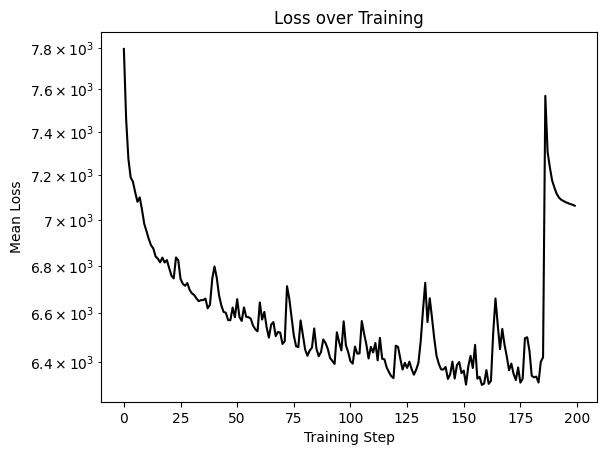

In [8]:
n_steps = 2000 #@param
information_penalty = 0

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = train,
    optimizer = optimizer,
    loss_fun = 'penalized_categorical',
    penalty_scale=information_penalty,
    n_steps=n_steps,
    do_plot=True,
    truncate_seq_length=200,
)

Step 3000 of 3000; Loss: 6.9727e+03. (Time: 305.9s)

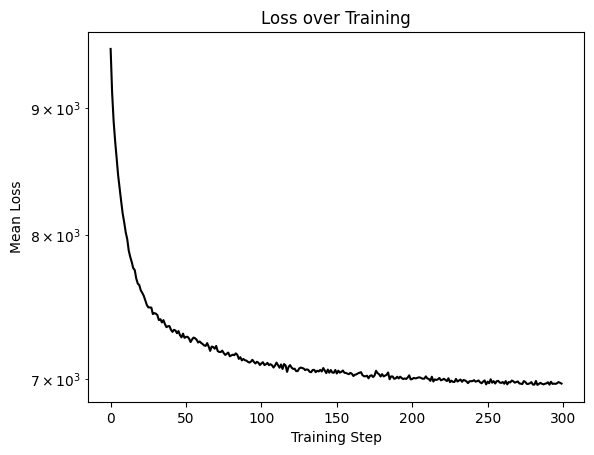

In [9]:
# Now fit more steps with a penalty, to encourage it to find a simple solution
# You can experiment with different values, but colab has been tested with 3000.
n_steps = 3000  #@param
information_penalty = 1e-3 #@param

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = train,
    optimizer = optimizer,
    loss_fun = 'penalized_categorical',
    params=disrnn_params,
    opt_state=opt_state,
    penalty_scale=information_penalty,
    n_steps=n_steps,
    truncate_seq_length=200,
)

Visualize model latents

(<Figure size 1000x500 with 3 Axes>,
 array([<Axes: title={'center': 'Latent Bottlenecks'}, ylabel='Latent #'>,
        <Axes: title={'center': 'Update MLP Bottlenecks'}, ylabel='Latent #'>],
       dtype=object))

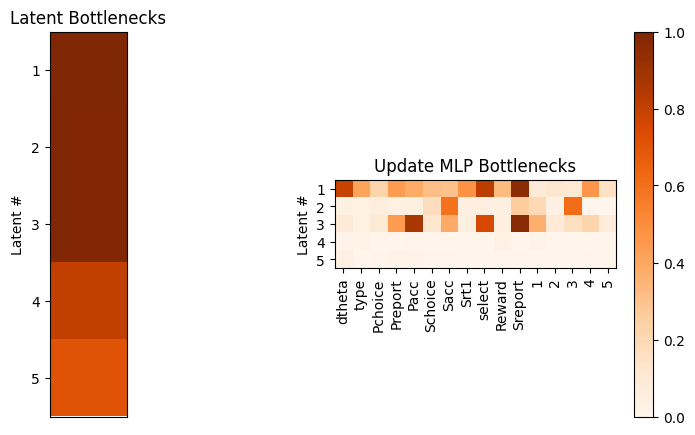

In [10]:
# Visualize bottleneck latents + learned update.
disrnn.plot_bottlenecks(disrnn_params, obs_names=features)
#disrnn.plot_update_rules(disrnn_params, make_disrnn_eval)


Normalized likelihoods

In [11]:
def compute_log_likelihood(dataset, model_fun, params):
  """Computes the log likelihood of the dataset under the model and the parameters.
  (the probability each choice we see in the dataset would have occurred in the model)
  
  Args:
    dataset: A DatasetRNN object.
    model_fun: A Haiku function that defines a network architecture.
    params: A set of params suitable for that network.
  """
  
  # It returns the normalized likelihood of the dataset under the model and the parameters as an output
  xs, actual_choices = next(dataset)
  n_trials_per_session, n_sessions = actual_choices.shape[:2]
  model_outputs, model_states = rnn_utils.eval_model(model_fun, params, xs)

  model_outputs = model_outputs[:, :, :-1]  
  # Computes the logarithm of the softmax function, which rescales elements to the range [-infinity,0)
  predicted_log_choice_probabilities = np.array(jax.nn.log_softmax(model_outputs[:, :, :-1])) # model_outputs[:,:,-1] is full of nans!

  log_likelihood = 0
  n = 0  # Total number of trials across sessions.
  for sess_i in range(n_sessions):
    for trial_i in range(n_trials_per_session):
      actual_choice = int(actual_choices[trial_i, sess_i])-1 # -1 because choices are between 1-6, to match the array indices
      if actual_choice >= 0:  # values < 0 are invalid trials which we ignore.
        log_likelihood += predicted_log_choice_probabilities[trial_i, sess_i, actual_choice]
        n += 1

  normalized_likelihood = np.exp(log_likelihood / n)

  print(f'Normalized Likelihood: {100 * normalized_likelihood:.1f}%')

  return normalized_likelihood

In [18]:
xs, actual_choices = next(train)
n_trials_per_session, n_sessions = actual_choices.shape[:2]
model_outputs, model_states = rnn_utils.eval_model(make_disrnn_eval, disrnn_params, xs)
model_outputs = model_outputs[:, :, :-1]

partner1 = np.argwhere(xsTrain_padded_LOOCV[:, :, 1] == 1)
partner2 = np.argwhere(xsTrain_padded_LOOCV[:, :, 1] == 2)[]



In [36]:
partner2[18,1]


9

In [17]:
print('Normalized Likelihoods for Disentangled RNN')
print('Training Dataset')
training_likelihood = compute_log_likelihood(
    train, make_disrnn_eval, disrnn_params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(
    train, make_disrnn_eval, disrnn_params)

Normalized Likelihoods for Disentangled RNN
Training Dataset


Normalized Likelihood: 6.6%
Held-Out Dataset


KeyboardInterrupt: 

Fit a model to convergence by repeatedly calling train_model:

(no information penalty)


In [13]:
# You can experiment with values, but n_steps_max = 5000 was used for testing.
# n_steps_max = 5000 #@param
# optimizer = optax.adam(learning_rate=1e-2)

# disrnn_conv_params, loss = rnn_utils.fit_model(
#     model_fun = make_disrnn,
#     dataset = train,
#     optimizer = optimizer,
#     loss_fun = 'penalized_categorical',
#     convergence_thresh=1e-3,
#     n_steps_max=n_steps_max)

In [14]:
# Compute quality-of-fit: Held-out Normalized Likelihood

# print('Normalized Likelihoods for Converged Disentangled RNN')
# print('Training Dataset')
# training_likelihood = compute_log_likelihood(train, make_disrnn, disrnn_conv_params)
# print('Held-Out Dataset')
# testing_likelihood = compute_log_likelihood(test, make_disrnn, disrnn_conv_params)